# Master Thesis 

The following notebook can be understood as a walkthrough through the experiments I ran for my master thesis.
To keep it somewhat clear I pushed large functions beyond the imports.

### 1. [Imports & functions](#imports&functions)
### 2. [Tryout-datasets](#datasets)
### 3. [Final datasets](#finalDatasets)
### 4. [Parameter tuning](#parameterTuning)
#### 4.1 [n - entity estimation](#nEntity)
#### 4.2 [reference entity estimation](#refEntity)
### 5. [Hypothesis testing](#hypothesisTesting)
#### 5.1 [Hypothesis 1](#hyp1)
#### 5.2 [Hypothesis 2](#hyp2)
#### 5.3 [Hypothesis 3](#hyp3)

# Imports and functions <a class="anchor" id="imports&functions"></a>

In [1]:
# for pretty code
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import multiprocessing as mp
import nltk.data
import statistics
import networkx as nx
import math
import warnings

from tqdm import tqdm_notebook, tnrange, tqdm
from matplotlib.pyplot import figure
from newsrelations.query_db.relation_query import DBQueryHandlerCoocc
from newsrelations.helper_classes.synonym_handler import SynonymHandler
from newsrelations.metrics.distances import DistanceMeasure
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

nltk.download("brown")
nltk.download("vader_lexicon")


tokenizer = nltk.data.load(
    "/home/jonas/anaconda3/lib/python3.7/nltk_data/punkt/english.pickle"
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)

[nltk_data] Error loading brown: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jonas/anaconda3/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<IPython.core.display.Javascript object>

In [3]:
def build_contingency_table_from_single_topic(
    relation_models_path, relation_models, topic_of_interest, no_entities=10
):
    """
    This function builds a contingency table from a input list of relation models generated with relation_miner.py 
    in regards to predetermined topic [TOPIC_OF_INTEREST].
    The first model in [RELATION_MODELS] is the reference model all other models will be compared with.
    The function extracts the top [NO_ENTITIES] co_occuring entities from the model and builds a contingency table.
    
    input:  relation_models = list
            relation_models_path = str 
            topic_of_interest = str           
            no_entities = int (standard 10)
            
    output: contingency_table = pandas DataFrame [rows = different models, columns = entities]
    """
    E1_SYNSET = 0
    E2_SYNSET = 1

    # initialize DistanceMeasure with reference-model
    dm = DistanceMeasure(relation_models_path, str(relation_models[0]))

    # extract top NO_ENTITIES entities
    top = dm.get_top_co_occurrences(
        topic_of_interest,
        cutoff=no_entities,
        e1_is_synset=E1_SYNSET,
        e2_is_synset=E2_SYNSET,
    )
    # write first row of contingency_table
    contingency_table = pd.DataFrame(
        np.array([t[1] for t in top]),
        index=[t[0] for t in top],
        columns=[str(relation_models[0])],
    )

    # loop through all remaining models
    for model in relation_models[1:]:
        # initialize db_handler()
        db_handler = DBQueryHandlerCoocc(relation_models_path, model)

        # buffer for cooccurrences
        co_occs = []
        # loop through all entities and get number of co-occurrences
        for row in contingency_table.index:
            co_occs.append(
                len(
                    list(
                        db_handler.select_relations(
                            e1=topic_of_interest.lower(),
                            e2=row.lower(),
                            e1_is_synset=E1_SYNSET,
                            e2_is_synset=E2_SYNSET,
                        )
                    )
                )
            )

        contingency_table[str(model)] = co_occs

    # transpose the contingency table to get it into the right format
    contingency_table = contingency_table.transpose()
    return contingency_table

<IPython.core.display.Javascript object>

In [4]:
def explain_models(relation_models):
    """
    This function lists the models from the relation_models list and their counter index
    
    Input: relation_models = list
    
    Output: None
    """
    i = 0
    for model in relation_models:
        print("model(" + str(i) + "): " + str(model))
        i += 1
    return

<IPython.core.display.Javascript object>

In [5]:
def build_contingency_table_from_topic_list(
    relation_models_path, relation_models, topic_of_interest_list, no_entities=10
):
    """
    This function builds a contingency table from a input list of relation models generated with relation_miner.py 
    in regards to predetermined topic list [topic_of_interest_list].
    The first model in [relation_models] is the reference model all other models will be compared with.
    The function extracts the top [no_entities] co-occuring entities for the first [topic_of_interest] from the 
    model and builds a contingency table.
    
    
    input:  relation_models = list
            relation_models_path = str 
            topic_of_interest_list = list           
            no_entities = int (standard 10)
            
    output: contingency_table = pandas DataFrame [rows = different models, columns = entities]
    """
    # identifier for models in relation_models_list
    i = 0
    # print models with idx
    explain_models(relation_models)

    # initialize DistanceMeasure with reference-model
    dm = DistanceMeasure(relation_models_path, str(relation_models[0]))

    # extract top NO_ENTITIES entities
    top = dm.get_top_co_occurrences(
        topic_of_interest_list[0], cutoff=no_entities, e1_is_synset=0, e2_is_synset=0
    )
    # write first row of contingency_table
    contingency_table = pd.DataFrame(
        np.array([t[1] for t in top]),
        index=[t[0] for t in top],
        columns=[str(topic_of_interest_list[0]) + " (" + str(i) + ")"],
    )

    # loop through the models
    for model in relation_models[:]:
        # initialize db_handler()
        db_handler = DBQueryHandlerCoocc(relation_models_path, model)

        for topic in topic_of_interest_list:
            # buffer for co-occurrencces
            co_occs = []

            # loop through all all entities and get number of co-occurrences
            for row in contingency_table.index:
                co_occs.append(
                    len(
                        list(
                            db_handler.select_relations(
                                e1=topic.lower(),
                                e2=row.lower(),
                                e1_is_synset=0,
                                e2_is_synset=0,
                            )
                        )
                    )
                )
            contingency_table[str(topic) + " (" + str(i) + ")"] = co_occs

        i += 1

    # transpose the contingency table to get it into the right format
    contingency_table = contingency_table.transpose()

    return contingency_table

<IPython.core.display.Javascript object>

In [6]:
def compare_entity_lists(
    relation_models_path, relation_models, topic_list1, topic_list2
):
    """
    This function creates a contingency table from a two input lists of entities [topic_list1][topic_list2]
    from a list of relation models 
    
    input:  relation_models = list
            relation_models_path = str 
            topic_list1 = list           
            topic_list2 = list
            
    output: contingency_table = pandas DataFrame [rows = different models, columns = entities]
    """
    # idx for models
    i = 0

    # print models with idx
    explain_models(relation_models)

    # initialize contingency_table
    contingency_table = pd.DataFrame(index=topic_list2)

    # loop through the models
    for model in relation_models:
        # initialize db_handler()
        db_handler = DBQueryHandlerCoocc(relation_models_path, model)

        for topic1 in topic_list1:
            # buffer for co-occurrencces
            co_occs = []

            # loop through all all entities and get number of co-occurrences
            for topic2 in topic_list2:
                co_occs.append(
                    len(
                        list(
                            db_handler.select_relations(
                                e1=topic1.lower(),
                                e2=topic2.lower(),
                                e1_is_synset=0,
                                e2_is_synset=0,
                            )
                        )
                    )
                )
            contingency_table[str(topic1) + " (" + str(i) + ")"] = co_occs

        i += 1

    # transpose the contingency table to get it into the right format
    contingency_table = contingency_table.transpose()

    return contingency_table

<IPython.core.display.Javascript object>

In [7]:
def chi_squared(contingency_table, print_orig = False, print_expect = False, print_chi_contr = False):
    """
    This function conducts a chi-squared test of independence between the different rows of a contingency table
    
    input: contingency_table
    
    ouput: None
    """
    contingency_table = sm.stats.Table(contingency_table)
    results = contingency_table.test_nominal_association()
    
    
    # orig contingency table
    if print_orig == True:
        print("Original contingency table:")
        print(contingency_table.table_orig)
    # expected values
    if print_expect == True:
        print("\nExpected values:")
        print(contingency_table.fittedvalues)
    # chi-squared contributions
    if print_chi_contr == True:
        print("\nChi-square contributions:")
        print(contingency_table.chi2_contribs)
    
    # results
    print("\nResults:")
    print(results)

   
    return


<IPython.core.display.Javascript object>

In [8]:
def do_chi_squared_comparison(
    relation_models_path, relation_models, topic_of_interest, no_entities
):
    """
    This function extracts chi-squared test results for all combinations of news-outlets
    
    input: contingency_table
    
    ouput: None
    """

    # extracting a contingency table from a single reference entity
    i = 0
    j = 0

    df_results = pd.DataFrame()

    for i in range(len(relation_models)):
        for j in range(len(relation_models)):
            models = []
            models = [relation_models[i]] + [relation_models[j]]

            contingency_table = build_contingency_table_from_single_topic(
                relation_models_path, models, topic_of_interest, no_entities
            )

            contingency_table = sm.stats.Table(contingency_table)
            results = contingency_table.test_nominal_association()

            df_results[
                str(relation_models[i][-10:-7])
                + " - "
                + str(relation_models[j][-10:-7])
            ] = [
                results.statistic,
                results.pvalue,
            ]

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: "chi_sq", 1: "p_value"})
    df_results

    return df_results

<IPython.core.display.Javascript object>

In [9]:
def entity_sentiment(reference_model):
    """
    This function calculates the sentiment of the top co-occurring entities between a reference news outlet 
    [reference_model] and other models. The sentiment is calculated of sentences which contain the co-occurring entity
    and neighbouring sentences within the scope of [SCOPE] sentences.
    Returns a dataframe with all necessary information
    
    Input:    reference_model (string)
              models (list)
              topic_of_interest (string)
    
    Output:   df_results (df)
    """
    models = RELATION_MODELS
    topic_of_interest = TOPIC_OF_INTEREST

    # initialize sentiment ananlyzer
    sid = SentimentIntensityAnalyzer()
    # extract list of top co-occurring entities
    dm = DistanceMeasure(RELATION_MODELS_PATH, str(reference_model))
    top = dm.get_top_co_occurrences(
        topic_of_interest, cutoff=NO_ENTITIES, e1_is_synset=0, e2_is_synset=1,
    )
    for i in range(len(top)):
        top[i] = top[i][0][:-5]
        top[i] = top[i].replace("_", " ")

    df_results = pd.DataFrame()

    # loop through all models
    for model in tqdm(models):
        if model == reference_model:
            continue
        else:
            # initialize db_handler
            description = str(str(reference_model[-10:-7]) + "-" + str(model[-10:-7]))
            db_handler = DBQueryHandlerCoocc(RELATION_MODELS_PATH, model)
            for topic in top:
                # retrieve co-occurrences without synsets
                articles = db_handler.get_articles_by_substring_text(topic)
                # convert generator (for count)
                articles = list(articles)

                sentiment_of_topic = []
                try:
                    for single_article in articles:
                        # get text, lower it and tokenize it into sentences
                        article = single_article.text
                        article = article.lower()
                        article_tokenized = tokenizer.tokenize(article)

                        # append buffers in the beginning and the end, in case the scope is overflowing
                        for i in range(0, SCOPE):
                            article_tokenized.append("buffer")
                            article_tokenized.insert(0, "buffer")

                        # extract compound sentiment score of each sector in a scope around the sentence
                        # in which the entity is mentioned
                        for line in range(0, len(article_tokenized)):
                            if TOPIC_OF_INTEREST in article_tokenized[line]:
                                sector = []
                                for i in range(line - SCOPE, line + 1 + SCOPE):
                                    sentiment = sid.polarity_scores(
                                        article_tokenized[i]
                                    )
                                    sector.append(sentiment["compound"])

                                # final sentiment as mean for the sector
                                final_sentiment = statistics.mean(sector)
                                # sentiment of topic as list for all final sentiments
                                sentiment_of_topic.append(final_sentiment)

                    # extract parameters and print
                    mean_sentiment = statistics.mean(sentiment_of_topic)
                    median_sentiment = statistics.median(sentiment_of_topic)
                    """
                    print("=" * 100)
                    print("outlet: " + description)
                    print("topic: " + topic)
                    print("mean sentiment: " + str(mean_sentiment))
                    print("median sentiment: " + str(median_sentiment))
                    print("\n")
                    """
                    results = [
                        [
                            str(reference_model[-10:-7]),
                            str(model[-10:-7]),
                            topic,
                            mean_sentiment,
                            median_sentiment,
                        ]
                    ]
                    df_results = df_results.append(results)
                except:
                    fail = [
                        [
                            str(reference_model[-10:-7]),
                            str(model[-10:-7]),
                            topic,
                            "NaN",
                            "NaN",
                        ]
                    ]
                    df_results = df_results.append(fail)
    df_results = df_results.rename(
        columns={
            0: "reference",
            1: "comparison",
            2: "topic",
            3: "mean_sentiment",
            4: "median_sentiment",
        }
    )
    df_results.reset_index()
    return df_results

<IPython.core.display.Javascript object>

In [10]:
def run_kmeans_on_sentiment(df):
    """
    This function runs a k-mean clustering on the sentiment vectors of each given input news-outlet from
    the input df and returns a dataframe with the labels of the calculated clusters per entity.

    input: df(Dataframe)
    
    output: df_res(Dataframe)
    
    """

    # splitting the df into list of dfs containing only one reference
    df_list = [df.loc[i : i + 80 - 1, :] for i in range(0, len(df), 80)]

    # list of dataframes, that contain the sorted mean_sentiments of comparisons per reference-news-outlet
    entity_frame_list = []

    for df_sublist in df_list:
        df_sublist = df_sublist.drop(columns=["reference", "median_sentiment"])
        df_sublist = df_sublist.reset_index(drop=True)

        df_subsublist = [
            df_sublist.loc[j : j + 10 - 1, :] for j in range(0, len(df_sublist), 10)
        ]

        entity = pd.DataFrame()

        for k in range(len(df_subsublist)):
            df_subsublist[k] = df_subsublist[k].reset_index(drop=True)
            s = df_subsublist[k]["comparison"][0]
            df_subsublist[k].index = df_subsublist[k]["topic"]
            df_subsublist[k] = df_subsublist[k].transpose()
            df_subsublist[k] = df_subsublist[k].drop("topic")
            df_subsublist[k] = df_subsublist[k].drop("comparison")
            df_subsublist[k].index = [s]
            entity = entity.append(df_subsublist[k])

        entity_frame_list.append(entity)

    # run k-means on the the sentiment vectors for each news-outlet and cluster into three groups
    df_res = pd.DataFrame(
        index=["NYT", "HFP", "WPO", "CNN", "RET", "NBC", "CTB", "FXN", "WSJ"]
    )

    for df in entity_frame_list:
        # NaNs are taken as neutral sentiment 0
        df = df.fillna(0)
        # clustering
        kmeans = KMeans(n_clusters=3).fit(df)
        # centroids = kmeans.cluster_centers_
        df["labels"] = kmeans.labels_

        df_res = pd.concat([df_res, df.labels], axis=1, sort=False)

    return df_res, entity_frame_list

<IPython.core.display.Javascript object>

In [11]:
import smtplib, ssl
from getpass import getpass

smtp_server = "smtp.gmail.com"
port = 587  # For starttls
sender_email = "pythonserver.jonas.m.ehrhardt@gmail.com"
password = getpass()

# Create a secure SSL context
context = ssl.create_default_context()


def message_me(calculation_ID):
    """
    This function sends me an email, when called, with the calculation ID given in input ;) 
    """
    # Try to log in to server and send email
    try:
        server = smtplib.SMTP(smtp_server, port)
        server.ehlo()  # Can be omitted
        server.starttls(context=context)  # Secure the connection
        server.ehlo()  # Can be omitted
        server.login(sender_email, password)

        sender = "pythonserver.jonas.m.ehrhardt@gmail.com"
        receivers = ["jonas@xorentec.de"]

        message = (
            "From: Jonas Pythonserver\nSubject: Calculation finished\nThe Calculation "
            + calculation_ID
            + " is finished..."
        )

        server.sendmail(sender, receivers, message)

        print("Successfully sent email")

    except Exception as e:
        print(e)
    finally:
        server.quit()

    return

········


<IPython.core.display.Javascript object>

In [12]:
message_me("test")

Successfully sent email


<IPython.core.display.Javascript object>

# 2. Tryout-datasets <a class="anchor" id="datasets"></a>

Different datasets scraped for testing purposes 

In [ ]:
# First Try
# general tryout on the NewsRelations Library

# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/firstTry"

# model name
RELATION_MODELS = [
    "model.sqlite",
]

In [ ]:
# Second Try
# models from newssources with different biases 
#
# -year:    2008 (for foxnews 2o08-2010)
# -domain:  politics
# -sources: NYT & foxnews 

# directory path of relation models 
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/secondTry"

# model nameslf, path_or_b
RELATION_MODELS = [
    "RMadvanced_2008_politics_nytimes.sqlite",
    "RM_2009_politics_nytimes.sqlite",
    "RM_2008-2010_politics_foxnews.sqlite",
]



In [ ]:
# Third Try
# models from newssources with different biases 
#
# -year:    2011
# -domain:  news
# -sources: reuters & national public radio

# directory path of relation models 
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/thirdTry"

# model names
RELATION_MODELS = [
    "RM_2011_news_reuters.sqlite",
    "RM_2011_news_npr.sqlite",
]



In [ ]:
# Fourth try
# two models from newssources with different biases each, for comparing slant coherence within
# different directions. Timeslots with gapless news reporting were chosen.
#
# -year:    2011-01-01 - 2011-03-31
# -domain:  news
# -sources(left):    New York Times (NYT) 637, Washington Post (WP) 508
#         (center):  National Public Radio (NPR) 109, Reuters (RET) 300
#         (right):   FoxNews (FN) 2735, Newsmax (NM) 180

# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/fourthTry"

# model names
RELATION_MODELS = [
    "RM_2011_news_NYT.sqlite",
    "RM_2011_news_WPO.sqlite",
    "RM_2011_news_NPR.sqlite",
    "RM_2011_news_RET.sqlite",
    "RM_2011_news_FXN.sqlite",
    "RM_2011_news_NMX.sqlite",
]


# 3. Final datasets <a class="anchor" id="finalDatasets"></a>

Datasets used for the thesis

In [ ]:
# Dataset for parameter tuning
# for the estiation of parameters number of entities and topic_of_interest
#
# -year:    2012
# -domain:  news
# -sources(left):    Huffington Post (HFP) 4909, New York Times (NYT) 2541,
#         (center):  CNN (CNN) 2491, Reuters (RET) 2135
#         (right):   FoxNews (FXN) 3784, (WSJ) 1215

# directory path of relation models
RELATION_MODELS_PATH = (
    "/home/jonas/Documents/GitHub/MasterThesis/models/calibrationDataset"
)

# model names
RELATION_MODELS = [
    "RM_2012_news_HFP.sqlite",
    "RM_2012_news_NYT.sqlite",
    "RM_2012_news_CNN.sqlite",
    "RM_2012_news_RET.sqlite",
    "RM_2012_news_FXN.sqlite",
    "RM_2012_news_WSJ.sqlite",
]

In [ ]:
# Final Dataset
# final daset based on works of Budak (2016) Flaxmann (2016) and Groseclose (2015)
#
# -year:    2011
# -domain:  news
# -sources(left):    Huffington Post (HFP) 14876, LA Times (LAT) 445, New York Times (NYT) 11281,
#                    Washington Post (WP) 14814, Daily KOS (DKO) 123
#         (center):  BBC (BBC) 52, CNN (CNN) 2652, Reuters (RET) 16767, Yahoo News (YHN) 211
#         (right):   Chicago Tribune (CTB) 2843, FoxNews (FXN) 6508, NBC (NBC) 3958, USA Today (UST) 171
#                    Wall Street Journal (WSJ) 2522, Breitbart (BBT) 76

# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/finalDataset"

# model names
RELATION_MODELS = [
    "RM_2011_news_BBC.sqlite",
    "RM_2011_news_BBT.sqlite",
    "RM_2011_news_CNN.sqlite",
    "RM_2011_news_CTB.sqlite",
    "RM_2011_news_DKO.sqlite",
    "RM_2011_news_FXN.sqlite",
    "RM_2011_news_HFP.sqlite",
    "RM_2011_news_LAT.sqlite",
    "RM_2011_news_NBC.sqlite",
    "RM_2011_news_NYT.sqlite",
    "RM_2011_news_RET.sqlite",
    "RM_2011_news_UST.sqlite",
    "RM_2011_news_WPO.sqlite",
    "RM_2011_news_WSJ.sqlite",
    "RM_2011_news_YHN.sqlite",
]


# 4. Parameter tuning <a class="anchor" id="parameterTuning"></a>

All parameter tuning is run with the [calibration dataset](#finalDatasets).
The categorization in slant groups is derived from literature.


## 4.1 n-entity estimation <a class="anchor" id="nEntity"></a>

Here I estimated the number of co-occurring entities (n) with the calibration dataset. Therefore I observe the curve of the p-value of the chi-squared test over an increasing number of n. 
For same-slant group news-outlets the p-value is expected to be very low, for different-slant news-outlets it is expected to be high (check [hypothesis 1](#hyp1) for explanation). 
For a high n the p-value of the different-slant news-outlets is expected to decrease again. Hence the optimal n  has a high count for p-values below 0.05 for same-slant outlets and a high count for p-values above 0.05 for different-slant news-outlets.

In [13]:
# Loading the dataset and set hyper-parameters

# directory path of relation models
RELATION_MODELS_PATH = (
    "/home/jonas/Documents/GitHub/MasterThesis/models/calibrationDataset"
)

# model names
RELATION_MODELS = [
    "RM_2012_news_HFP.sqlite",
    "RM_2012_news_NYT.sqlite",
    "RM_2012_news_CNN.sqlite",
    "RM_2012_news_RET.sqlite",
    "RM_2012_news_FXN.sqlite",
    "RM_2012_news_WSJ.sqlite",
]

# path to results folder
RESULTS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/results/"

# max number of entities + 1, to compare with the reference entity
NO_ENTITIES = 31

# reference entity -
TOPIC_OF_INTEREST = "obama"

<IPython.core.display.Javascript object>

In [ ]:
# estimate optimal n - within same-slant-constellations
models = [
    [RELATION_MODELS[0], RELATION_MODELS[1]],
    [RELATION_MODELS[1], RELATION_MODELS[0]],
    [RELATION_MODELS[2], RELATION_MODELS[3]],
    [RELATION_MODELS[3], RELATION_MODELS[2]],
    [RELATION_MODELS[4], RELATION_MODELS[5]],
    [RELATION_MODELS[5], RELATION_MODELS[4]],
]

# initialize dataframes
df = pd.DataFrame()

# loop through model constellation in models list
def estimate_n_same_slant(models):
    df_results = pd.DataFrame()
    description = str(str(models[0][-10:-7]) + "-" + str(models[1][-10:-7]))
    # loop through entity numbers until max entity is reached
    for n in tnrange(1, NO_ENTITIES, desc=description):
        # create SQL query and build contingency table for sm.stats
        contingency_table = build_contingency_table_from_single_topic(
            RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, n
        )
        contingency_table = sm.stats.Table(contingency_table)
        # calculate results + add them to dataframe
        results = contingency_table.test_nominal_association()
        df_results[n] = [results.pvalue]

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: description})
    
    return df_results


# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(pool.map(estimate_n_same_slant, [model for model in models]), axis=1)

# close loop
pool.close()


# save results to csv
df.to_csv(
    RESULTS_PATH + "nSameSlant_" + TOPIC_OF_INTEREST + ".csv", index=False
)

message_me("nSameSlant")

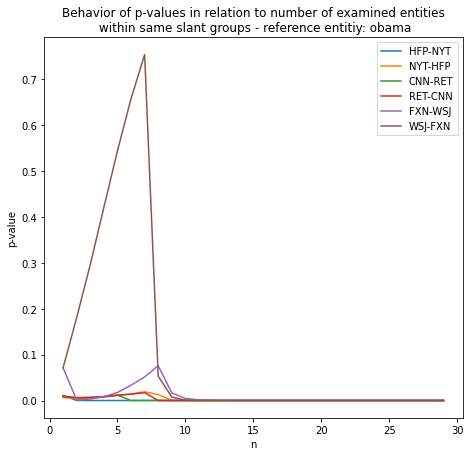

<IPython.core.display.Javascript object>

In [14]:
# import dataset
df_same = pd.read_csv(RESULTS_PATH + "nSameSlant_" + TOPIC_OF_INTEREST + ".csv")

# Visualze dataset
df_same.plot(kind="line", figsize=(7.5, 7))
plt.ylabel("p-value")
plt.xlabel("n")
plt.title(
    "Behavior of p-values in relation to number of examined entities\n within same slant groups - reference entitiy: "
    + TOPIC_OF_INTEREST
)
plt.legend()
plt.show()

In [ ]:
# estimate optimal n - within different-slant-constellations
models = [
    [RELATION_MODELS[0], RELATION_MODELS[2]],
    [RELATION_MODELS[0], RELATION_MODELS[3]],
    [RELATION_MODELS[0], RELATION_MODELS[4]],
    [RELATION_MODELS[0], RELATION_MODELS[5]],
    [RELATION_MODELS[1], RELATION_MODELS[2]],
    [RELATION_MODELS[1], RELATION_MODELS[3]],
    [RELATION_MODELS[1], RELATION_MODELS[4]],
    [RELATION_MODELS[1], RELATION_MODELS[5]],
    [RELATION_MODELS[2], RELATION_MODELS[0]],
    [RELATION_MODELS[2], RELATION_MODELS[1]],
    [RELATION_MODELS[2], RELATION_MODELS[4]],
    [RELATION_MODELS[2], RELATION_MODELS[5]],
    [RELATION_MODELS[3], RELATION_MODELS[0]],
    [RELATION_MODELS[3], RELATION_MODELS[1]],
    [RELATION_MODELS[3], RELATION_MODELS[4]],
    [RELATION_MODELS[3], RELATION_MODELS[5]],
    [RELATION_MODELS[4], RELATION_MODELS[0]],
    [RELATION_MODELS[4], RELATION_MODELS[1]],
    [RELATION_MODELS[4], RELATION_MODELS[2]],
    [RELATION_MODELS[4], RELATION_MODELS[3]],
    [RELATION_MODELS[5], RELATION_MODELS[0]],
    [RELATION_MODELS[5], RELATION_MODELS[1]],
    [RELATION_MODELS[5], RELATION_MODELS[2]],
    [RELATION_MODELS[5], RELATION_MODELS[3]],
]

# initialize dataframes and counter for column name
df = pd.DataFrame()


def estimate_n_diff_slant(models):
    # loop through model constellation in models list
    # for constellation in tqdm(models):
    df_results = pd.DataFrame()
    description = str(str(models[0][-10:-7]) + "-" + str(models[1][-10:-7]))
    # loop through entity numbers until max entity is reached
    for n in tnrange(1, NO_ENTITIES, desc=description):

        # create SQL query and build contingency table for sm.stats
        contingency_table = build_contingency_table_from_single_topic(
            RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, n
        )
        contingency_table = sm.stats.Table(contingency_table)
        # calculate results + add them to dataframe
        results = contingency_table.test_nominal_association()
        df_results[n] = [results.pvalue]

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: description})

    return df_results


# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(pool.map(estimate_n_diff_slant, [model for model in models]), axis=1)

# close loop
pool.close()


# save results to csv
df.to_csv(
    RESULTS_PATH + "nDiffSlant_" + TOPIC_OF_INTEREST + ".csv", index=False
)

message_me("nDiffSlant_All")

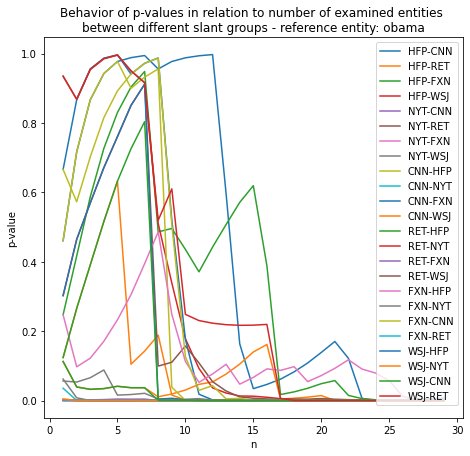

<IPython.core.display.Javascript object>

In [15]:
# import dataset
df_diff = pd.read_csv(RESULTS_PATH + "nDiffSlant_" + TOPIC_OF_INTEREST + ".csv")

# Visualze
df_diff.plot(kind="line", figsize=(7.5, 7.0))
plt.xlabel("n")
plt.ylabel("p-value")
plt.title(
    "Behavior of p-values in relation to number of examined entities \nbetween different slant groups - reference entity: "
    + TOPIC_OF_INTEREST
)
plt.legend()
plt.show()

## 4.2 Reference entity estimation <a class="anchor" id="refEntity"></a>

To estimate the optimal reference entity for the co-occurrences, the behavior of different and same-slant news-outlets are compared. A good reference entity gets high p-values for different-slant news-outlets and low p-values for same-slant news-outlets.
The tested entities are derived from Gentzkow and Shapiro (2010).

In [16]:
# hyper-parameters
# directory path of relation models
RELATION_MODELS_PATH = (
    "/home/jonas/Documents/GitHub/MasterThesis/models/calibrationDataset"
)

# model names
RELATION_MODELS = [
    "RM_2012_news_HFP.sqlite",
    "RM_2012_news_NYT.sqlite",
    "RM_2012_news_CNN.sqlite",
    "RM_2012_news_RET.sqlite",
    "RM_2012_news_FXN.sqlite",
    "RM_2012_news_WSJ.sqlite",
]

# path to results folder
RESULTS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/results/"

# number of entities to compare with the reference entitiy
NO_ENTITIES = 16

# reference entities
TOPIC_OF_INTEREST_LIST = [
    "sport",
    "obama",
    "bush",
    "united_states",
    "healthcare",
    "insurance",
    "gun",
    "school",
    "death_tax",
    "terrorism",
    "Germany",
    "France",
    "health_care",
]

<IPython.core.display.Javascript object>

In [ ]:
# initialize dataframes and counter for column name
df = pd.DataFrame()

# same-slant news-outlets
models = [RELATION_MODELS[0], RELATION_MODELS[1]]
# different-slant news-outlets
# models = [RELATION_MODELS[0], RELATION_MODELS[4]]

def estimate_optimal_reference_entity(topic):
    # loop through model constellation in models list
    # for constellation in tqdm(models):
    df_results = pd.DataFrame()
    description = str(str(models[0][-10:-7]) + "-" + str(models[1][-10:-7]))
    # loop through entity numbers until max entity is reached
    for n in tnrange(1, NO_ENTITIES, desc=topic):
        try:
            # create SQL query and build contingency table for sm.stats
            contingency_table = build_contingency_table_from_single_topic(
                RELATION_MODELS_PATH, models, topic, n
            )
            contingency_table = sm.stats.Table(contingency_table)
            # calculate results + add them to dataframe
            results = contingency_table.test_nominal_association()
            df_results[n] = [results.pvalue]
        except:
            print("There is too little data for " + topic)
            break

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: topic})

    return df_results


# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(
    pool.map(estimate_optimal_reference_entity, [topic for topic in TOPIC_OF_INTEREST_LIST]),
    axis=1,
)

# close pool
pool.close()

# save results to csv
df.to_csv(RESULTS_PATH + "reference_entity_estimation_diff.csv", index=False)
# df.to_csv(RESULTS_PATH + "reference_entity_estimation_same.csv", index=False)

message_me("reference_estimation")

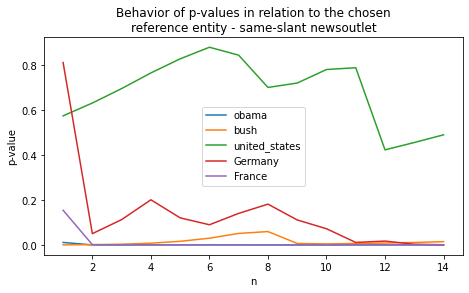

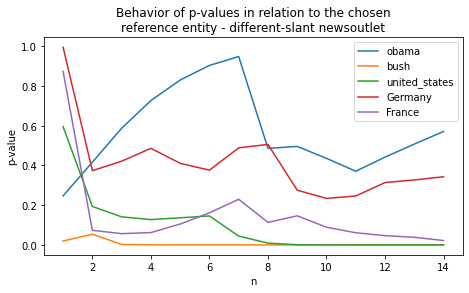

<IPython.core.display.Javascript object>

In [17]:
# Import and visualize - same-slant news-outlet
df_same = pd.read_csv(RESULTS_PATH + "reference_entity_estimation_same.csv")

df_same.plot(kind="line", figsize=(7.5, 4))
plt.xlabel("n")
plt.ylabel("p-value")
plt.title(
    "Behavior of p-values in relation to the chosen\nreference entity - same-slant newsoutlet"
)
plt.show()

# Import and visualize - diff-slant news-outlet
df_diff = pd.read_csv(RESULTS_PATH + "reference_entity_estimation_diff.csv")

df_diff.plot(kind="line", figsize=(7.5, 4))
plt.xlabel("n")
plt.ylabel("p-value")
plt.title(
    "Behavior of p-values in relation to the chosen\nreference entity - different-slant newsoutlet"
)
plt.show()


# 5. Hypothesis testing <a class="anchor" id="hypothesisTesting"></a>

## 5.1 Hypothesis 1<a class="anchor" id="hyp1"></a>

1.1 Within same slant groups the co-occurring entities are independent from the news-outlet

1.2 Between different slant groups the co-occurring entities are dependent from the news-outlet
    
To check hypothesis 1 I ran chi-squared tests for same (1.1) and different-slant (1.2) news-outlets.
The results are matched with news-outlet groupings from literature. Accuracy, precision, recall and F1-score are estimated individually and combined.


In [18]:
# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/finalDataset"

# model names
RELATION_MODELS = [
    "RM_2011_news_CNN.sqlite",
    "RM_2011_news_CTB.sqlite",
    "RM_2011_news_FXN.sqlite",
    "RM_2011_news_HFP.sqlite",
    "RM_2011_news_NBC.sqlite",
    "RM_2011_news_NYT.sqlite",
    "RM_2011_news_RET.sqlite",
    "RM_2011_news_WPO.sqlite",
    "RM_2011_news_WSJ.sqlite",
]

# path to results folder
RESULTS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/results/"

# reference entity
TOPIC_OF_INTEREST = "obama"

# number of co-occurring entities + 1
NO_ENTITIES = 11

<IPython.core.display.Javascript object>

In [ ]:
# compare everything with everything
models = []

# set up list of model combinations
for i in RELATION_MODELS:
    for j in RELATION_MODELS:
        if i == j:
            continue
        else:
            models.append([i, j])

# initialize dataframes and counter for column name
df = pd.DataFrame()

def hello_kitty_action_plan(models):
    # loop through model constellation in models list
    df_results = pd.DataFrame()
    description = str(str(models[0][-10:-7]) + "-" + str(models[1][-10:-7]))
    try:
        # create SQL query and build contingency table for sm.stats
        contingency_table = build_contingency_table_from_single_topic(
            RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, NO_ENTITIES
        )
        contingency_table = sm.stats.Table(contingency_table)
        # calculate results + add them to dataframe
        results = contingency_table.test_nominal_association()
        df_results[description] = [str(models[0][-10:-7]), str(models[1][-10:-7]), description, results.statistic, results.pvalue]
    except:
        print("There is too little data for " + TOPIC_OF_INTEREST)

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: "reference", 1:"comparison", 2: "combination", 3: str("chi_sq"), 4: str("p_value")})

    return df_results


# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(pool.map(hello_kitty_action_plan, [model for model in models]), axis=0)

# close pool 
pool.close()

# save results to csv
df.to_csv(
    RESULTS_PATH + "hyp1_" + TOPIC_OF_INTEREST + ".csv", index=False
)


message_me("hyp1")


In [19]:
df = pd.read_csv(RESULTS_PATH + "hyp1_" + TOPIC_OF_INTEREST + ".csv")


<IPython.core.display.Javascript object>

In [20]:
# only necessary to run, if result csv is imported.
df["reference"] = 1
df["comparison"] = 1
df["ones"] = 1
for i in range(len(df)):
    df.reference[i] = df.combination[i][:3]
    df.comparison[i] = df.combination[i][-3:]
df["same_chi"] = 1
df["same_lit"] = 1

<IPython.core.display.Javascript object>

In [21]:
# add labels for evaluating accuracy, precision and recall
liberal = ["NYT", "HFP", "WPO"]
center = ["CNN", "RET", "NBC"]
conservative = ["CTB", "FXN", "WSJ"]


for i in range(len(df)):
    # adding labels, derived from the chi-test
    if df.p_value[i] <= 0.05:
        df.same_chi[i] = 1
    else:
        df.same_chi[i] = 0
    
    # adding labels, derived from literature
    if all(x in liberal for x in [df.reference[i], df.comparison[i]]) == True:
        df.same_lit[i] = 1
    elif all(x in center for x in [df.reference[i], df.comparison[i]]) == True:
        df.same_lit[i] = 1
    elif all(x in conservative for x in [df.reference[i], df.comparison[i]]) == True:
        df.same_lit[i] = 1
    else:
        df.same_lit[i] = 0



<IPython.core.display.Javascript object>

### Results hypothesis 1.1

In [22]:
# split into two dataframes df_same and df_diff
df_same = pd.DataFrame()
df_diff = pd.DataFrame()

for i in range(len(df)):
    if all(x in liberal for x in [df.reference[i], df.comparison[i]]) == True:
        df_same = df_same.append(df.loc[i])
    elif all(x in center for x in [df.reference[i], df.comparison[i]]) == True:
        df_same = df_same.append(df.loc[i])
    elif all(x in conservative for x in [df.reference[i], df.comparison[i]]) == True:
        df_same = df_same.append(df.loc[i])
    else:
        df_diff = df_diff.append(df.loc[i])

df_same = df_same.reset_index()
df_diff = df_diff.reset_index()

<IPython.core.display.Javascript object>

In [23]:
# Results for Hyp 1.1
y_true = df_same.same_lit
y_pred = df_same.same_chi

target_names = ["diff", "same"]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


              precision    recall  f1-score   support

        diff     0.0000    0.0000    0.0000         0
        same     1.0000    0.7222    0.8387        18

    accuracy                         0.7222        18
   macro avg     0.5000    0.3611    0.4194        18
weighted avg     1.0000    0.7222    0.8387        18



<IPython.core.display.Javascript object>

### Results hypothesis 1.2

In [24]:
# Results for Hyp 1.2
y_true = df_diff.same_lit
y_pred = df_diff.same_chi

target_names = ["diff", "same"]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


              precision    recall  f1-score   support

        diff     1.0000    0.2593    0.4118        54
        same     0.0000    0.0000    0.0000         0

    accuracy                         0.2593        54
   macro avg     0.5000    0.1296    0.2059        54
weighted avg     1.0000    0.2593    0.4118        54



<IPython.core.display.Javascript object>

### Combined results

In [25]:
# Results for overall precision
y_true = df.same_lit
y_pred = df.same_chi

target_names = ["diff", "same"]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


              precision    recall  f1-score   support

        diff     0.7368    0.2593    0.3836        54
        same     0.2453    0.7222    0.3662        18

    accuracy                         0.3750        72
   macro avg     0.4911    0.4907    0.3749        72
weighted avg     0.6140    0.3750    0.3792        72



<IPython.core.display.Javascript object>

## 5.2 Hypothesis 2 <a class="anchor" id="hyp2"></a>

Goal of hypothesis 2 estimates whether there are other possibilities to categorize news-outlets into similar slant groups. 
Therefore a graph is constructed from the news-outlets. The news-outlets are represented by nodes, the edges by the chi-value of the news-outlet tuples. The chi-statistic was chosen, since it respects differences in the number of articles of the compared news-outlets.

The graphs were constructed as directed and undirected graphs.
For each Version the local clustering coefficient of each node was calculated after Opsahl and Panzarasa (2009).

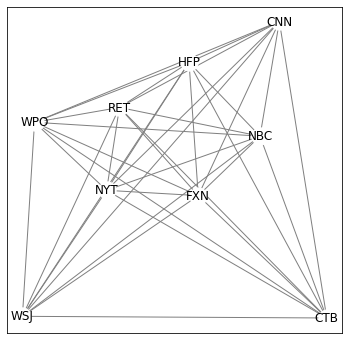

<IPython.core.display.Javascript object>

In [26]:
# visualize as directed weighted graph
G_weighted = nx.Graph()

for i in range(len(df)):
    G_weighted.add_edge(df.reference[i], df.comparison[i], weight=(df.chi_sq[i]))

nx.spring_layout(G_weighted)
plt.figure(figsize=(6, 6))
nx.draw_networkx(G_weighted, with_labels=True, edge_color="gray", node_color="white")

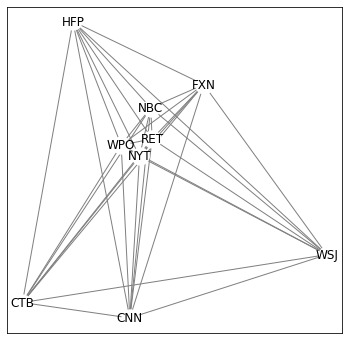

<IPython.core.display.Javascript object>

In [27]:
# Visualize as undirected weighted graph.
# The edge, weights are combined and averaged 

df_new = pd.DataFrame()
G_new = nx.Graph()

for i in range(len(df)):
    k = pd.DataFrame()
    for j in range(len(df)):
        if (
            df.reference[i] == df.comparison[j]
            and df.reference[j] == df.comparison[i]
            and i != j
        ):
            l = [
                str(df.reference[i]),
                str(df.comparison[i]),
                ((df.chi_sq[i] + df.chi_sq[j])),
            ]
            G_new.add_edge(
                str(df.reference[i]),
                str(df.comparison[i]),
                weight=(((df.chi_sq[i]+df.chi_sq[j])/2)*100),
            )
            k = k.append(l)
            k = k.transpose()
            df_new = df_new.append(k)

nx.spring_layout(G_new)
plt.figure(figsize=(6, 6))
plt.axis = "off"
nx.draw_networkx(G_new, with_labels=True, edge_color="gray", node_color="white")

df_new = df_new.rename(columns={0: "reference", 1: "comparison", 2: "summed_chi_sq"})


In [28]:
## calculate the clustering coefficient for each node
# normal cluster coefficient not useful since interconnected and weighted --> therefore Opsahl et al. (2009)

# triplet values - arithmetic, geometric, max, min --> best results with geometric

# split into list of dfs containing only one reference node
df_list = [df.loc[i : i + 8 - 1, :] for i in range(0, len(df), 8)]

df_coefficient = pd.DataFrame()

# loop over every single node
for df_single in df_list:
    df_single = df_single.reset_index()
    total_value = 0

    # loop over the weights of all connected nodes
    for j in range(len(df_single) - 1):
        # geometric
        total_value = total_value + math.sqrt(
            df_single.chi_sq[j] * df_single.chi_sq[j + 1]
        )
        # arithmetic
        # total_value = total_value + ((df_single.chi_sq[j] * df_single.chi_sq[j + 1])/2)
        # max
        # total_value = total_value + max(df_single.chi_sq[j], df_single.chi_sq[j + 1])
        # min
        # total_value = total_value + min(df_single.chi_sq[j], df_single.chi_sq[j + 1])

    for i in range(len(df_single) - 1):
        # geometric
        triplet_value = math.sqrt(df_single.chi_sq[i] * df_single.chi_sq[i + 1])
        # arithmetic
        # triplet_value = ((df_single.chi_sq[i] * df_single.chi_sq[i + 1])/2)
        # max
        # triplet_value = max(df_single.chi_sq[i], df_single.chi_sq[i + 1])
        # min
        # triplet_value = min(df_single.chi_sq[i], df_single.chi_sq[i + 1])

        cluster_coefficient = triplet_value / total_value
        buffer = [
            [
                df_single.reference[i],
                df_single.comparison[i],
                df_single.comparison[i + 1],
                triplet_value,
                cluster_coefficient,
            ]
        ]
        df_coefficient = df_coefficient.append(buffer)

df_coefficient = df_coefficient.reset_index()
df_coefficient

"""
# print out triangles that have a cluster coefficient bigger, than X
for i in range(len(df_coefficient)):
    if df_coefficient[4][i] >= 0.5:
        print(df_coefficient.loc[i])
    else:
        continue
"""

'\n# print out triangles that have a cluster coefficient bigger, than X\nfor i in range(len(df_coefficient)):\n    if df_coefficient[4][i] >= 0.5:\n        print(df_coefficient.loc[i])\n    else:\n        continue\n'

<IPython.core.display.Javascript object>

### 5.3 Hypothesis 3 <a class="anchor" id="hyp3"></a>

Since it is possible to cluster news-outlets via their co-occurrences, hypothesis 3 assumes, that a combination of sentiment analysis and the clustering by co-occurrences could identify slant groups.

First same-slant groups are identified by extracting only the sentiment of all co-occurring entities and the sentiment of their context. Therefore, scope (s) is defined that determines the number of sentences around the sentence in which a co-occurring entity is mentioned. The sentiment of all sentences within the scope is estimated.
Expirements are run with s=0 and s=1, since the likelihood of neutral sentiment increases with the number of analyzed sentences. The resulting vectors of each news-outlet and each co-occurring entity are clusterd via k-means into three groups 


In [29]:
# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/finalDataset"

# model names
RELATION_MODELS = [
    "RM_2011_news_CNN.sqlite",
    "RM_2011_news_CTB.sqlite",
    "RM_2011_news_FXN.sqlite",
    "RM_2011_news_HFP.sqlite",
    "RM_2011_news_NBC.sqlite",
    "RM_2011_news_NYT.sqlite",
    "RM_2011_news_RET.sqlite",
    "RM_2011_news_WPO.sqlite",
    "RM_2011_news_WSJ.sqlite",
]

# path to results folder
RESULTS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/results/"

# reference entity
TOPIC_OF_INTEREST = "obama"

# number of co-occurring entites
NO_ENTITIES = 10

<IPython.core.display.Javascript object>

In [ ]:
# extracting the mean and median sentiment of all entity co-occurrences and news-outlet-combinations
# with a scope of 1

df = pd.DataFrame()

# number of sentences arount the sentence, that includes the entity
SCOPE = 1

# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(pool.map(entity_sentiment, [model for model in RELATION_MODELS]), axis=0)

# close pool
pool.close()

df = df.reset_index()

# save results to csv
df.to_csv(RESULTS_PATH + "sentimentAll_scope1_" + TOPIC_OF_INTEREST + ".csv", index=False)


message_me("sentiment_all_scope_1")

In [32]:
df_scope1 = pd.read_csv(RESULTS_PATH + "sentimentAll_scope1_" + TOPIC_OF_INTEREST + ".csv")


<IPython.core.display.Javascript object>

In [33]:
df_res, entity_frame_list = run_kmeans_on_sentiment(df_scope1)


<IPython.core.display.Javascript object>

In [ ]:
# extracting the mean and median sentiment of all entity co-occurrences and news-outlet-combinations
# with a scope of 0

df = pd.DataFrame()

# number of sentences arount the sentence, that includes the entity
SCOPE = 0

# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(pool.map(entity_sentiment, [model for model in RELATION_MODELS]), axis=0)

# close pool
pool.close()

df = df.reset_index()

# save results to csv
df.to_csv(
    RESULTS_PATH + "sentimentAll_scope0_" + TOPIC_OF_INTEREST + ".csv", index=False
)


message_me("sentiment_all_calibration")

In [34]:
df_scope0 = pd.read_csv(RESULTS_PATH + "sentimentAll_scope0_" + TOPIC_OF_INTEREST + ".csv")


<IPython.core.display.Javascript object>

In [35]:
df_res, entity_frame_list = run_kmeans_on_sentiment(df_scope0)


<IPython.core.display.Javascript object>

In [ ]:
# create residual tables

model_list = []
for i in range(len(RELATION_MODELS)):
    model = [RELATION_MODELS[i]]
    for j in range(len(RELATION_MODELS)):
        if i != j:
            model.append(RELATION_MODELS[j])

    model_list.append(model)

# print(model_list)

models = []
for model in model_list:
    models = models + model

df_new["index"] = pd.Series(models)
df_new

getting the co-occurrence residuals involved

In [36]:
# create residual tables

# create list of all possible combinations
model_list = []
for i in range(len(RELATION_MODELS)):
    model = [RELATION_MODELS[i]]
    for j in range(len(RELATION_MODELS)):
        if i != j:
            model.append(RELATION_MODELS[j])

    model_list.append(model)
    


def create_residual_table(models):
    # create SQL query and build contingency table for sm.stats
    contingency_table = build_contingency_table_from_single_topic(
        RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, 10,
    )
    # create residual table
    contingency_table = sm.stats.Table(contingency_table)
    residual_table = contingency_table.chi2_contribs

    # sort alphabetically
    residual_table = residual_table.sort_index()

    return residual_table

# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df_new = pd.concat(pool.map(create_residual_table, [model for model in model_list]))

# close pool
pool.close()

# save results to csv
df.to_csv(RESULTS_PATH + "sentimentAll_residualTable_" + TOPIC_OF_INTEREST + ".csv", index=False)


message_me("residual_table")


Process ForkPoolWorker-8:
  File "/home/jonas/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-7:
Traceback (most recent call last):
  File "/home/jonas/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jonas/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jonas/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/home/jonas/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-36-9d1836a3f7e7>", line 18, in create_residual_table
    RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, 10,
  File "/home/jonas/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Pr

  File "<ipython-input-36-9d1836a3f7e7>", line 18, in create_residual_table
    RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, 10,
  File "<ipython-input-3-0538b57ed046>", line 28, in build_contingency_table_from_single_topic
    e2_is_synset=E2_SYNSET,
  File "/home/jonas/.local/lib/python3.7/site-packages/newsrelations/metrics/distances.py", line 98, in <listcomp>
    rel = sorted([x.e1 if x.e2 == query_name else x.e2 for x in relations])
  File "<ipython-input-3-0538b57ed046>", line 28, in build_contingency_table_from_single_topic
    e2_is_synset=E2_SYNSET,
  File "/home/jonas/.local/lib/python3.7/site-packages/newsrelations/metrics/distances.py", line 118, in get_top_co_occurrences
    res = self.get_dict_from_relations(relations_e1, query_name_e1)
  File "/home/jonas/.local/lib/python3.7/site-packages/newsrelations/metrics/distances.py", line 98, in <listcomp>
    rel = sorted([x.e1 if x.e2 == query_name else x.e2 for x in relations])
  File "/home/jonas/.local/lib/python3.7/si

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [37]:
df_residuals = pd.read_csv(
    RESULTS_PATH + "sentimentAll_residualTable_" + TOPIC_OF_INTEREST + ".csv"
)

<IPython.core.display.Javascript object>

In [38]:
# do some transformations to the df
df_residuals = df_residuals[df_residuals.columns[:11]]
contingency_list = [
    df_residuals.loc[i : i + 9 - 1, :] for i in range(0, len(df_residuals), 9)
]

combined_entity_residuals = []

for i in range(len(contingency_list)):
    # delete reference news-outlet and sort it alphabetically to bring it in format of entity_frame_list
    contingency_list[i] = contingency_list[i].reset_index(drop=True)
    contingency_list[i] = contingency_list[i].drop(index=[i])

    # delete string value
    contingency_list[i] = contingency_list[i].loc[
        :, ~contingency_list[i].columns.str.contains("^Unnamed")
    ]

    # labels for columns and indices
    combined_entity_index = [entity_frame_list[i].index]
    combined_entity_columns = [contingency_list[i].columns]

    # reindex all dataframes
    contingency_list[i] = contingency_list[i].reset_index(drop=True)
    contingency_list[i] = contingency_list[i].T.reset_index(drop=True).T
    entity_frame_list[i] = entity_frame_list[i].reset_index(drop=True)
    entity_frame_list[i] = entity_frame_list[i].T.reset_index(drop=True).T

    # taking reciproke of contingency list weight small differences in coverage bigger and vice versa
    contingency_list[i] = 1 / contingency_list[i]

    # fill NaNs with zeros (neutral sentiment if not mentioned)
    contingency_list[i] = contingency_list[i].fillna(0)
    entity_frame_list[i] = entity_frame_list[i].fillna(0)

    combined_entity_residuals.append(
        pd.DataFrame(entity_frame_list[i] * contingency_list[i],)
    )

for i in range(len(combined_entity_residuals)):
    combined_entity_residuals[i].index = combined_entity_index
    combined_entity_residuals[i].columns = combined_entity_columns

<IPython.core.display.Javascript object>

In [39]:
df_res = pd.DataFrame()

for i in range(len(combined_entity_residuals)):
    kmeans = KMeans(n_clusters=3).fit(combined_entity_residuals[i])
    labels = kmeans.labels_
    df_res[str("labels" + str(i))] = labels
df_res

,labels0,labels1,labels2,labels3,labels4,labels5,labels6,labels7,labels8
0,2,2,2,2,2,0,1,2,0
1,0,1,1,1,1,0,2,1,1
2,0,1,0,0,0,0,0,0,0
3,2,0,0,0,2,0,0,0,2
4,0,1,0,0,0,1,0,0,0
5,0,1,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0
7,1,1,0,0,0,2,0,0,0


<IPython.core.display.Javascript object>